In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Alphabet import IUPAC
from Bio.SeqRecord import SeqRecord
from Bio import SeqUtils
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFECV
import scikitplot as skplt
from sklearn import metrics
from scipy.stats import mannwhitneyu
from sklearn.metrics import confusion_matrix

In [6]:
with open('../lasso f1', 'r') as f:
    a = f.readlines()
a = [s[:-1] for s in a]

In [7]:
c = [s for s in a if len(s) < 6]

In [8]:
b = [s for s in a if len(s) == 6]

In [9]:
b1,b2 = b[:283], b[283:]

In [13]:
#b1, b2 = b[:9], b[9:]

In [5]:
#b1,b2 = b[:370], b[370:]

In [10]:
df1 = pd.concat([pd.read_csv('../ppnnw5.csv')[['Gen', 'die']], 
                 pd.read_csv('../ppnnw5.csv')[c], 
                 pd.read_csv('../ppnnw6.csv')[b]
                ], axis = 1)
df1 = df1.loc[df1['die'] == 'no']
df1['Gen'] = 1

df2 = pd.read_csv('../h1sk.csv')[['die']]
df2 = pd.concat([df2, 
                 pd.read_csv('../h1w5.csv')[c], 
                 pd.read_csv('../h1w6p1.csv')[b1],
                 pd.read_csv('../h1w6p2.csv')[b2]],
                axis = 1)
df2 = df2.loc[df2['die'] == 'no']
df2['Gen'] = 0

In [11]:
data = pd.concat([df1,df2], axis = 0).reset_index(drop = True)

In [36]:
X = data.iloc[:, 2:].astype(float)
y = data.iloc[:, 0].astype(float)

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25)    

In [37]:
sum(y_train == 1.0)

3055

In [11]:
def rf(data, split, nest, crt, cvf):
    #Splitting features and labels
    X = data.iloc[:, 2:].values.astype(float)
    y = data.iloc[:, 0].values.astype(float)
    
    # Splitting the dataset into the Training set and Test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = split)
    
    # Feature Scaling
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    
    
    # Fitting Random Forest Classification to the Training set
    classifier = RandomForestClassifier(n_estimators = nest, criterion = crt)
    classifier.fit(X_train, y_train)
    
    # Predicting the Test set results
    y_pred = classifier.predict(X_test)
    
    # Making the Confusion Matrix
#     cm = confusion_matrix(y_test, y_pred)

    #feature selection 1
    selector1 = SelectFromModel(RandomForestClassifier(n_estimators = 200))
    selector1.fit(X_train, y_train)
    
    cv_bin = cross_val_score(classifier, X, y, cv=cvf, scoring='f1')
    cv_mac = cross_val_score(classifier, X_train, y_train, cv=cvf, scoring='f1_macro')
    f1bin = f1_score(y_test, y_pred, average='binary')
    f1mac = f1_score(y_test, y_pred, average='macro')
    
    
    dunnowhat = metrics.accuracy_score(y_test, y_pred)
    y_pred_proba = classifier.predict_proba(X_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.legend(loc=4)
    plt.show()
    
    return cv_mac, cv_bin, f1mac, f1bin, selector1

In [27]:
a = pd.DataFrame(columns = range(len(sl.get_support())))

In [30]:
a.iloc[:,sl.get_support()]

,0,2,3,4,7,8,9,11,12,13,...,632,637,638,642,643,648,652,664,666,667


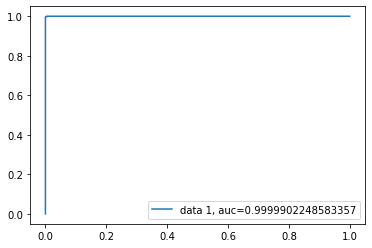

In [13]:
cv1, cv2, fm, fb, sl = rf(data, 0.25, 200, 'entropy', 10)
a = list(data.iloc[:,2:].columns[sl.get_support()])

In [6]:
a = []
for i in range(0,1364,682):
    df1 = pd.concat([pd.read_csv('../ppnnw5.csv')[['Gen', 'die']], 
                 pd.read_csv('../ppnnw5.csv').iloc[:,i+10:i+682+10]], axis = 1)
    df1 = df1.loc[df1['die'] == 'no']
    df1['Gen'] = 1

    df2 = pd.read_csv('../h1sk.csv')[['die']]
    df2 = pd.concat([df2, pd.read_csv('../h1w5.csv').iloc[:,i+5:i+682+5]], axis = 1)
    df2 = df2.loc[df2['die'] == 'no']
    df2['Gen'] = 0
    data = pd.concat([df1,df2], axis = 0).reset_index(drop = True)
    cv, sl = rf(data, 0.25, 200, 'entropy', 10)
    a = a + list(data.iloc[:,2:].columns[sl.get_support()])

# for i in range(0,2048,512):
#     df1 = pd.concat([pd.read_csv('../ppnnw5.csv')[['Gen', 'die']], 
#                  pd.read_csv('../ppnnw6.csv').iloc[:,i+10:i+512+10]], axis = 1)
#     df1 = df1.loc[df1['die'] == 'no']
#     df1['Gen'] = 1

#     df2 = pd.read_csv('../h1sk.csv')[['die']]
#     df2 = pd.concat([df2, pd.read_csv('../h1w6p1.csv').iloc[:,i+5:i+512+5]], axis = 1)
#     df2 = df2.loc[df2['die'] == 'no']
#     df2['Gen'] = 0
#     data = pd.concat([df1,df2], axis = 0).reset_index(drop = True)
#     cv, sl = rf(data, 0.25, 200, 'entropy', 10)
#     a = a + list(data.iloc[:,2:].columns[sl.get_support()])
    
# for i in range(0,2048,512):
#     df1 = pd.concat([pd.read_csv('../ppnnw5.csv')[['Gen', 'die']], 
#                  pd.read_csv('../ppnnw6.csv').iloc[:,i+10+2048:i+512+10+2048]], axis = 1)
#     df1 = df1.loc[df1['die'] == 'no']
#     df1['Gen'] = 1

#     df2 = pd.read_csv('../h1sk.csv')[['die']]
#     df2 = pd.concat([df2, pd.read_csv('../h1w6p2.csv').iloc[:,i+5:i+512+5]], axis = 1)
#     df2 = df2.loc[df2['die'] == 'no']
#     df2['Gen'] = 0
#     data = pd.concat([df1,df2], axis = 0).reset_index(drop = True)
#     cv, sl = rf(data, 0.25, 200, 'entropy', 10)
#     a = a + list(data.iloc[:,2:].columns[sl.get_support()])    

In [7]:
a = ['AATCG', 'ACGAT', 'ATACG', 'ATC', 'ATCA', 'ATCG', 'ATCGA', 'ATTCG', 
                                                  'CAAT', 'CAATC', 'CGAAT', 'CGAT', 'CGATA', 'CGATC', 'CGATT', 'CGTA', 
                                                  'GAT', 'GATC', 'GTCAA', 'TATCG', 'TCAA', 'TCAAT', 'TCGA', 'TCGAT', 'TCGTA', 
                                                  'TGAT',
    'ACGATA', 'ATATCG', 'ATCGAT', 'TAATCG', 
                                               'TAGTCG', 'TCAATC', 'TCGATA', 'TCGATC', 'TCGGTA',
    'CAATCG', 'CAATTG', 'CCGATA', 'CGATAA', 'CGATAC', 'CGATAG', 'CGATAT', 'CGATCA', 
                                               'CGATTA', 'CGATTG', 'CGCATA', 'CGGTAT', 'GTCGAT', 'GTCGTA', 'GTTGAT']

In [8]:
len(a)

50

In [23]:
len(a)

50

In [15]:
with open('ph f1', 'r') as f:
    b = f.readlines()

In [54]:
a = (d + e)

In [24]:
with open('ph f2', 'w') as f:
    for item in a:
        f.write(item)
        f.write('\n')

In [56]:
b = [s for s in a if len(s) == 6]
c = [s for s in a if len(s) != 6]

In [23]:
cb.mean()

0.9860434508456443

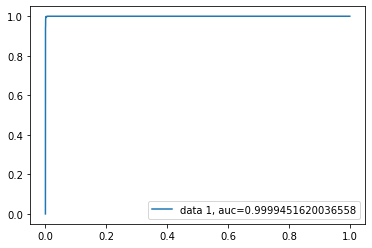

In [12]:
cm, cb, fm, fb, sl = rf(data, 0.25, 280, 'entropy', 10)

In [84]:
df1 = pd.concat([pd.read_csv('../ppnnw5.csv')[['Gen', 'die']], pd.read_csv('../ppnnw6.csv').iloc[:,10:]], axis = 1)
df1 = df1.loc[df1['die'] == 'no']
df1.loc[df1['Gen'] == 'ssRNA(+)', 'Gen'] = 0
df1.loc[df1['Gen'] == 'ssRNA(+)i', 'Gen'] = 0
df1.loc[df1['Gen'] == 'ssRNA(-)', 'Gen'] = 1
df1.loc[df1['Gen'] == 'ssRNA(-)g', 'Gen'] = 1
cv, sl = rf(df1, 0.25, 200, 'entropy', 10)
a = a + list(df1.iloc[:,2:].columns[sl.get_support()])

In [86]:
b = [s for s in a if len(s) == 6]
c = [s for s in a if len(s) != 6]

In [87]:
with open('pn f1', 'w') as f:
    for item in a:
        f.write(item)
        f.write('\n')

In [97]:
cv

array([0.95042781, 0.95921438, 0.92466885, 0.95921438, 0.96777894,
       0.94909091, 0.94909091, 0.93980176, 0.9669386 , 0.89239548])

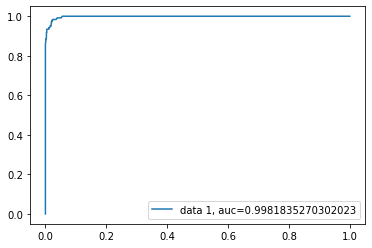

In [93]:
df1 = pd.concat([pd.read_csv('../ppnnw5.csv')[['Gen', 'die']], pd.read_csv('../ppnnw5.csv')[c],
                 pd.read_csv('../ppnnw6.csv')[b]], axis = 1)
df1 = df1.loc[df1['die'] == 'no']
df1.loc[df1['Gen'] == 'ssRNA(+)', 'Gen'] = 0
df1.loc[df1['Gen'] == 'ssRNA(+)i', 'Gen'] = 0
df1.loc[df1['Gen'] == 'ssRNA(-)', 'Gen'] = 1
df1.loc[df1['Gen'] == 'ssRNA(-)g', 'Gen'] = 1
cv, sl = rf(df1, 0.25, 200, 'entropy', 10)

In [ ]:
# data = pd.concat([df1,df2], axis = 0).reset_index(drop = True)

# currentmax = 0
# sel = []
# for i1 in range(10):
#     wd1 = pd.concat([data.iloc[:, :2], data.iloc[:,sel]], axis = 1)
#     for i in range(2,len(data.columns)):
#         wd = pd.concat([wd1, data.iloc[:,i]], axis = 1)
#         cv = rf(wd, 0, 200, 'entropy', 10)
#         em = cv.mean() / cv.std()
#         if em > currentmax:
#             best = i
#             currentmax = em           
    
#     sel.append(best)    
#     print(i1)


In [30]:
sl.get_support()

array([False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False,  True, False, False,  True, False,
        True, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False,  True, False, False,
        True,  True,  True, False, False, False, False, False,  True,
        True, False, False, False, False,  True,  True, False, False,
       False,  True,  True, False, False, False, False, False, False,
       False, False,  True,  True,  True, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False,

In [50]:
len(d)

115

In [49]:
len(e)

47

In [ ]:
d = list(data.iloc[:,2:].columns[sl.get_support()])

In [48]:
e = list(data.iloc[:,2:].columns[sl.get_support()])

In [ ]:
len(a + b + c + d)

In [ ]:
for i in range(1000):
    t1, t2 = (mannwhitneyu(df1.iloc[:,i],df2.iloc[:,i]))
    if t2 > 0.1:
        print(t2)

In [ ]:
data = pd.concat([df1, df2], axis = 0).reset_index(drop = True)

In [ ]:
a = data.describe().transpose()

In [ ]:
a['CoV'] = a['std'] / a['mean']

In [ ]:
b = df1.describe().transpose()

In [ ]:
b['CoV'] = b['std'] / b['mean']

In [ ]:
b.sort_values(by='CoV')

In [ ]:
a.sort_values(by='CoV')[-60:]

In [ ]:
a.sort_values(by='CoV')[-50:].index

In [24]:
data

,Gen,die,AG,AC,TC,GT,AAA,ATC,AGA,TTG,...,CCGATA,CCGATT,CCGTAA,CCGTAT,CCGTTA,CCGTTG,CCCAAT,CCCAGG,CCCAGC,CCCTGG
0,1,no,0.119526,0.127035,0.110160,0.123551,0.049686,0.028280,0.036019,0.048168,...,0.000173,0.000177,0.000187,0.000151,0.000165,0.000203,0.000268,0.000139,0.000116,0.000146
1,1,no,0.132761,0.129035,0.105699,0.100634,0.060535,0.034410,0.042203,0.036442,...,0.000125,0.000152,0.000233,0.000103,0.000250,0.000137,0.000299,0.000091,0.000214,0.000166
2,1,no,0.140190,0.121886,0.109577,0.112542,0.051023,0.031324,0.042150,0.040512,...,0.000163,0.000301,0.000232,0.000226,0.000099,0.000134,0.000198,0.000092,0.000215,0.000117
3,1,no,0.114674,0.102935,0.115402,0.138423,0.030611,0.027276,0.029369,0.055619,...,0.000162,0.000308,0.000256,0.000368,0.000307,0.000391,0.000401,0.000280,0.000382,0.000218
4,1,no,0.156303,0.133713,0.088494,0.111181,0.045899,0.025641,0.051623,0.027247,...,0.000267,0.000288,0.000428,0.000236,0.000132,0.000239,0.000624,0.001019,0.000462,0.000835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19585,0,no,0.114698,0.118881,0.136894,0.093469,0.057703,0.035787,0.031208,0.030303,...,0.000057,0.000109,0.000125,0.000083,0.000010,0.000083,0.001212,0.000229,0.000250,0.001452
19586,0,no,0.150412,0.110343,0.114682,0.099166,0.028513,0.021250,0.045892,0.020833,...,0.000068,0.000062,0.000099,0.000047,0.000062,0.000078,0.000473,0.001623,0.001316,0.001701
19587,0,no,0.131806,0.104411,0.109047,0.095748,0.038129,0.019168,0.040522,0.022530,...,0.000650,0.000109,0.000104,0.000052,0.000078,0.000151,0.001389,0.000593,0.002253,0.002628
19588,0,no,0.138806,0.121283,0.113225,0.109758,0.041604,0.027091,0.039886,0.035160,...,0.000625,0.000115,0.000047,0.000073,0.000073,0.000125,0.000161,0.000901,0.001510,0.001359


In [26]:
#univariate selection
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
X = data.iloc[:,2:]  #independent columns
y = data.iloc[:,0]    #target column i.e price range
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(50,'Score'))  #print 10 best features

#the features look like trash.

      Specs     Score
18      CTG  7.422552
81     CCTG  6.933247
64     CAAT  5.912581
7       TTG  5.861852
237  AAAAAA  5.519743
12      GTT  5.516744
5       ATC  5.492606
17      CAG  5.380199
54     GTTG  5.340992
82    AAAAA  5.325840
58     GGAG  5.010996
15      CAA  4.815639
72     CTGC  4.792962
71     CTGG  4.786157
20      CGT  4.707807
75     CGTA  4.597403
11      GTA  4.521964
62     GCTG  4.447443
69     CAGC  4.391878
74     CGAT  4.376222
63     GCCT  4.224596
8       TCG  4.167357
76     CGTT  4.079333
207   CCTGG  4.003859
46     TCGA  3.968006
68     CAGG  3.813492
80     CCAG  3.798244
21     AAAA  3.739874
65     CAAC  3.738410
10      GAG  3.720704
45     TCAA  3.699968
490  TTTTTT  3.691693
13      GGA  3.637641
23     ATTG  3.594061
39     TTGA  3.534532
128   TTTTT  3.510355
61     GCAG  3.447414
19      CGA  3.394055
25     ATCA  3.379072
47     TCGT  3.342995
206   CCTGC  3.312833
27     ATCG  3.194147
66     CATA  3.160427
235   CAGCC  3.133469
189   GCCT

In [13]:
#feature importance
X = data.iloc[:, 2:200]#.values.astype(float)
y = data.iloc[:, 0]#.values.astype(float)

# Splitting the dataset into the Training set and Test set
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)

# Feature Scaling
sc = StandardScaler()
X = sc.fit_transform(X)
#X_test = sc.transform(X_test)    
    
# Fitting Random Forest Classification to the Training set
classifier = RandomForestClassifier(n_estimators = 200, criterion = 'entropy')
classifier.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

[2.10975815e-04 1.01131235e-03 9.24699431e-04 1.75634613e-03
 3.42029262e-04 6.43650905e-03 5.19985213e-04 9.30985741e-04
 4.51378824e-04 1.17957037e-03 1.19026924e-03 1.41823284e-03
 5.03100234e-04 4.23074672e-04 1.15618088e-03 4.41513232e-03
 1.59838851e-03 9.33916996e-04 9.94365099e-04 1.11125666e-04
 3.26125179e-04 6.00791973e-04 1.44269177e-03 9.35570149e-04
 7.50952517e-04 2.52635179e-03 1.18380345e-03 6.19077372e-03
 3.69322285e-04 5.10793332e-04 1.30339637e-03 1.73294284e-04
 6.21319538e-04 1.60199663e-03 5.66068896e-04 4.59348016e-04
 1.17670604e-02 2.70031393e-04 4.31511817e-04 1.15874205e-03
 1.41736507e-03 3.41821848e-04 1.76317190e-03 1.21618258e-03
 1.83151025e-03 6.67112140e-03 6.00676799e-03 2.75536789e-03
 2.03529697e-04 4.93840806e-04 1.44256298e-03 7.27446965e-04
 1.34246097e-04 8.54712713e-04 1.18420576e-02 1.28004361e-04
 2.04024799e-04 2.96797418e-04 9.49790752e-04 7.69926368e-03
 5.60367181e-03 7.04722374e-04 6.52114216e-04 5.83861939e-04
 9.70828055e-03 7.610664

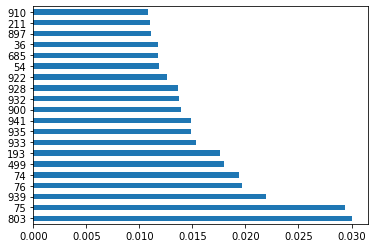

In [47]:
print(classifier.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(classifier.feature_importances_, index=range(len(data.columns) - 2))
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

In [39]:
feat_importances.nlargest(50).index

Int64Index([803,  75, 939,  76,  74, 499, 193, 933, 935, 941, 900, 932, 928,
            922,  54, 685,  36, 897, 211, 910, 820, 298, 590,  64, 146, 688,
            217, 286, 797,  59,  65, 765, 912, 898, 132, 962, 920, 227, 593,
             45,   5,  27,  46, 572,  60, 408, 144, 435, 409, 771],
           dtype='int64')

In [45]:
data.columns[feat_importances.nlargest(50).index - 2]

Index(['CAATGG', 'CTGG', 'CGGTTA', 'CTGC', 'CTGT', 'TTGATG', 'GCCTG', 'CGTCAT',
       'CGGATA', 'CGGTTG', 'CGATAT', 'CGTCAA', 'CGTTGG', 'CGTACG', 'GATC',
       'GTCAAT', 'ACGT', 'CGAATT', 'CCTGG', 'CGACAT', 'CATAGT', 'ATTGTC',
       'TCGTGA', 'GGTT', 'TCAAC', 'GTCGAA', 'CGCAA', 'ATACTC', 'GCCCTG',
       'GTTC', 'GCAG', 'GCTGGG', 'CGTAAT', 'CGAACA', 'TTTTT', 'CCTGGA',
       'CGTACA', 'CGACA', 'TCGGAT', 'TTGC', 'AC', 'ATTG', 'TTCG', 'TCGAAA',
       'GTCA', 'ACGTTC', 'TGCGT', 'TAACAC', 'ACGTCA', 'GCGATG'],
      dtype='object')

In [ ]:
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

KeyboardInterrupt: 

In [20]:
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif
from statsmodels.stats.multicomp import pairwise_tukeyhsd
X,y = data.iloc[:,2:].values, data.iloc[:,0].values
chi2_score, chi_2_p_value = chi2(X,y)
f_score, f_p_value = f_classif(X,y)
mut_info_score = mutual_info_classif(X,y)
pairwise_tukeyhsd = [list(pairwise_tukeyhsd(X[:,i],y).reject) for i in range(4)]
print('chi2 score        ', chi2_score)
print('chi2 p-value      ', chi_2_p_value)
print('F - score score   ', f_score)
print('F - score p-value ', f_p_value)
print('mutual info       ', mut_info_score)
print('pairwise_tukeyhsd',pairwise_tukeyhsd)

MemoryError: Unable to allocate 145. MiB for an array with shape (19590, 972) and data type float64

In [9]:
X,y = data.iloc[:,2:].values, data.iloc[:,0].values
y_ = y == 0

KeyboardInterrupt: 

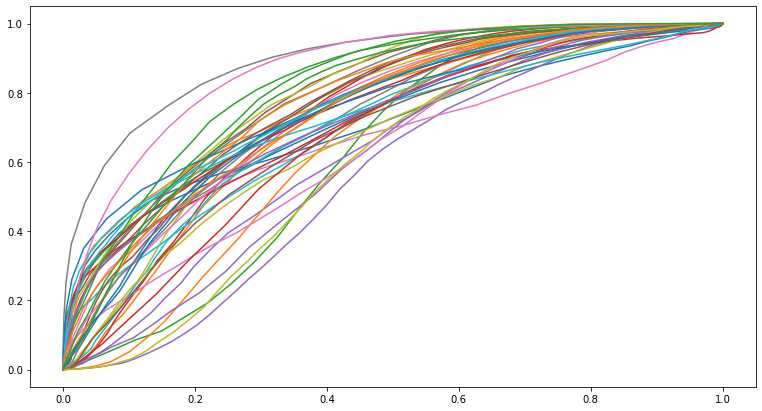

In [11]:
from sklearn.metrics import auc
import numpy as np


plt.figure(figsize=(13,7))
for col in range(X.shape[1]):
    tpr,fpr = [],[]
    for threshold in np.linspace(min(X[:,col]),max(X[:,col]),100):
        detP = X[:,col] < threshold
        tpr.append(sum(detP & y_)/sum(y_))# TP/P, aka recall
        fpr.append(sum(detP & (~y_))/sum((~y_)))# FP/N
        
    if auc(fpr,tpr) < .5:
        aux = tpr
        tpr = fpr
        fpr = aux
    plt.plot(fpr,tpr,label=data.columns[col] + ', auc = '\
                           + str(np.round(auc(fpr,tpr),decimals=3)))
plt.title('ROC curve - Iris features')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [34]:
import sys
!{sys.executable} -m pip install pymrmr

    ERROR: Command errored out with exit status 1:
     command: 'c:\users\michael\appdata\local\programs\python\python38-32\python.exe' -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\Michael\\AppData\\Local\\Temp\\pip-install-gondstxs\\pymrmr\\setup.py'"'"'; __file__='"'"'C:\\Users\\Michael\\AppData\\Local\\Temp\\pip-install-gondstxs\\pymrmr\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record 'C:\Users\Michael\AppData\Local\Temp\pip-record-99rs2wqx\install-record.txt' --single-version-externally-managed --compile
         cwd: C:\Users\Michael\AppData\Local\Temp\pip-install-gondstxs\pymrmr\
    Complete output (94 lines):
    running install
    running build
    running build_py
    package init file 'pymrmr\__init__.py' not found (or not a regular file)
    running egg_info
    writing pymrmr.egg-info\PKG-INFO
    writin


  Using cached https://files.pythonhosted.org/packages/b3/ab/903712947a2f5cd1af249132885dbd81ae8bf8cfd30fb3b3f2beddab23e8/pymrmr-0.1.8.tar.gz
  Running setup.py install for pymrmr: started
    Running setup.py install for pymrmr: finished with status 'error'


In [30]:
#mRMR
import pandas as pd
import pymrmr
pymrmr.mRMR(data, 'MIQ', 10)

ModuleNotFoundError: No module named 'pymrmr'

In [22]:
X,y = data.iloc[:,2:], data.iloc[:,0]

In [24]:
def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature
cor_support, cor_feature = cor_selector(X, y, 50)
print(str(len(cor_feature)), 'selected features')

50 selected features


In [25]:
cor_feature

['ATACG',
 'TCGTTG',
 'TATCG',
 'CAAC',
 'TCGATA',
 'GTAC',
 'TTGTCG',
 'AATCG',
 'TCGAA',
 'CGCATA',
 'CGTAG',
 'CAAT',
 'TTGCGA',
 'TTGACG',
 'TTCG',
 'AACG',
 'ACGTA',
 'GTCGAT',
 'GTCGTA',
 'ACGAT',
 'CAATC',
 'ATTGCG',
 'CGATT',
 'GTCGA',
 'CGATTG',
 'CGTAT',
 'TAACG',
 'CGTAC',
 'CAATTG',
 'CGCAAT',
 'CGTTA',
 'TCGT',
 'GGTA',
 'CGGTA',
 'CGTTGA',
 'GCGTA',
 'TTGCG',
 'TCGAT',
 'GTTG',
 'TCGTA',
 'CGTAA',
 'CAATCG',
 'TCGA',
 'TACG',
 'CGATA',
 'CGTTG',
 'ATCG',
 'CGTT',
 'CGAT',
 'CGTA']

In [28]:
data.corr()

,Gen,AG,AC,TC,GT,AAA,ATC,AGA,TTG,TCG,...,CCGATA,CCGATT,CCGTAA,CCGTAT,CCGTTA,CCGTTG,CCCAAT,CCCAGG,CCCAGC,CCCTGG
Gen,1.000000,-0.319588,0.360284,0.261824,0.393869,-0.082873,0.480004,-0.242032,0.359794,0.423960,...,0.444654,0.394785,0.403674,0.390391,0.404199,0.398905,0.274492,-0.343819,-0.347666,-0.297875
AG,-0.319588,1.000000,0.023008,-0.612569,-0.240467,0.215283,-0.277422,0.833258,-0.319709,-0.361209,...,-0.125521,-0.189162,-0.158341,-0.199933,-0.208647,-0.241990,-0.167610,0.173825,0.118131,0.016523
AC,0.360284,0.023008,1.000000,-0.041629,-0.321336,0.200405,0.329182,0.135098,-0.138537,0.006336,...,0.214613,0.130493,0.203880,0.158388,0.148098,0.035988,0.219247,-0.181979,-0.153102,-0.211997
TC,0.261824,-0.612569,-0.041629,1.000000,0.114050,-0.212060,0.501713,-0.461806,0.244710,0.379085,...,0.151636,0.224138,0.142596,0.169665,0.169237,0.169777,0.254014,-0.125170,-0.076445,-0.071052
GT,0.393869,-0.240467,-0.321336,0.114050,1.000000,-0.190036,0.046388,-0.291516,0.518668,0.243563,...,0.137680,0.151718,0.215982,0.249740,0.258192,0.345248,-0.072044,-0.236300,-0.294149,-0.179812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCGTTG,0.398905,-0.241990,0.035988,0.169777,0.345248,-0.322333,-0.022485,-0.305197,0.050509,0.484199,...,0.229307,0.276276,0.232543,0.254034,0.361709,1.000000,0.114177,-0.000259,-0.002404,0.042955
CCCAAT,0.274492,-0.167610,0.219247,0.254014,-0.072044,-0.094546,0.223090,-0.140449,0.014751,0.103116,...,0.141187,0.138923,0.100542,0.093273,0.084128,0.114177,1.000000,-0.018793,-0.005839,-0.019662
CCCAGG,-0.343819,0.173825,-0.181979,-0.125170,-0.236300,-0.559047,-0.587456,-0.172514,-0.640051,0.144303,...,-0.177612,-0.153278,-0.179415,-0.166158,-0.183788,-0.000259,-0.018793,1.000000,0.699637,0.668484
CCCAGC,-0.347666,0.118131,-0.153102,-0.076445,-0.294149,-0.542731,-0.571462,-0.215192,-0.645723,0.177252,...,-0.170506,-0.139102,-0.170110,-0.167150,-0.186145,-0.002404,-0.005839,0.699637,1.000000,0.625973


In [36]:
import sys
!{sys.executable} -m pip install shap

  Running setup.py install for shap: started
    Running setup.py install for shap: finished with status 'done'


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [22]:
import shap

# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(X)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0][0,:], X[0,:])

# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X)


AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [ ]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X)

In [ ]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("RM", shap_values, X)

In [ ]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X)

In [ ]:
shap.summary_plot(shap_values, X, plot_type="bar")

In [39]:
import matplotlib
from sklearn.linear_model import LinearRegression
matplotlib.rcParams.update({'font.size': 12})
print (len(X), len(y))
lr = LinearRegression()
lr.fit(X, y)
rr = Ridge(alpha=0.01) # higher the alpha value, more restriction on the coefficients; low alpha > more generalization, coefficients are barely
# restricted and in this case linear and ridge regression resembles
rr.fit(X, y)
rr100 = Ridge(alpha=100) #  comparison with alpha value
rr100.fit(X, y)
train_score=lr.score(X, y)
test_score=lr.score(X, y)
Ridge_train_score = rr.score(X,y)
Ridge_test_score = rr.score(X, y)
Ridge_train_score100 = rr100.score(X,y)
Ridge_test_score100 = rr100.score(X, y)

19590 19590


linear regression train score: 0.8804947273194044
linear regression test score: 0.8804947273194044
ridge regression train score low alpha: 0.8804947272569158
ridge regression test score low alpha: 0.8804947272569158
ridge regression train score high alpha: 0.8792419357638076
ridge regression test score high alpha: 0.8792419357638076


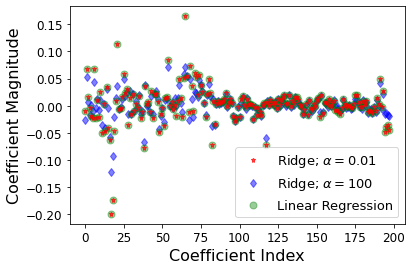

In [40]:
print ("linear regression train score:", train_score)
print ("linear regression test score:", test_score)
print ("ridge regression train score low alpha:", Ridge_train_score)
print ("ridge regression test score low alpha:", Ridge_test_score)
print ("ridge regression train score high alpha:", Ridge_train_score100)
print ("ridge regression test score high alpha:", Ridge_test_score100)
plt.plot(rr.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Ridge; $\alpha = 0.01$',zorder=7) # zorder for ordering the markers
plt.plot(rr100.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'Ridge; $\alpha = 100$') # alpha here is for transparency
plt.plot(lr.coef_,alpha=0.4,linestyle='none',marker='o',markersize=7,color='green',label='Linear Regression')
plt.xlabel('Coefficient Index',fontsize=16)
plt.ylabel('Coefficient Magnitude',fontsize=16)
plt.legend(fontsize=13,loc=4)
plt.show()

In [2]:
import sys, os

os.path.dirname(sys.executable)

'c:\\users\\michael\\appdata\\local\\programs\\python\\python38-32'

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

In [9]:
sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear'))
sel_.fit(sc.fit_transform(data.iloc[:,2:500]), data.iloc[:,0])

SelectFromModel(estimator=LogisticRegression(C=1, class_weight=None, dual=False,
                                             fit_intercept=True,
                                             intercept_scaling=1, l1_ratio=None,
                                             max_iter=100, multi_class='auto',
                                             n_jobs=None, penalty='l1',
                                             random_state=None,
                                             solver='liblinear', tol=0.0001,
                                             verbose=0, warm_start=False),
                max_features=None, norm_order=1, prefit=False, threshold=None)

In [11]:
sel_.get_support()
selected_feat = data.iloc[:,2:500].columns[(sel_.get_support())]
print('total features: {}'.format((data.iloc[:,2:].shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
      np.sum(sel_.estimator_.coef_ == 0)))

total features: 972
selected features: 212
features with coefficients shrank to zero: 286
